Fetching MNIST from OpenML...
Loaded MNIST via OpenML: (70000, 784) (70000,)
Using subset: (20000, 784) (20000,)
Train/test sizes: (16000, 784) (4000, 784)

Grid searching KNN (no PCA)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
No-PCA best params: {'knn__n_neighbors': 3, 'knn__weights': 'distance'} CV acc: 0.9161876868335392 took 47.2s

--- NO PCA Test accuracy: 0.9263 ---
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       393
           1       0.94      0.99      0.97       448
           2       0.96      0.91      0.93       408
           3       0.90      0.92      0.91       412
           4       0.92      0.91      0.91       366
           5       0.93      0.89      0.91       365
           6       0.96      0.96      0.96       399
           7       0.90      0.92      0.91       431
           8       0.93      0.88      0.91       382
           9       0.88      0.90      0.89       396

    accu

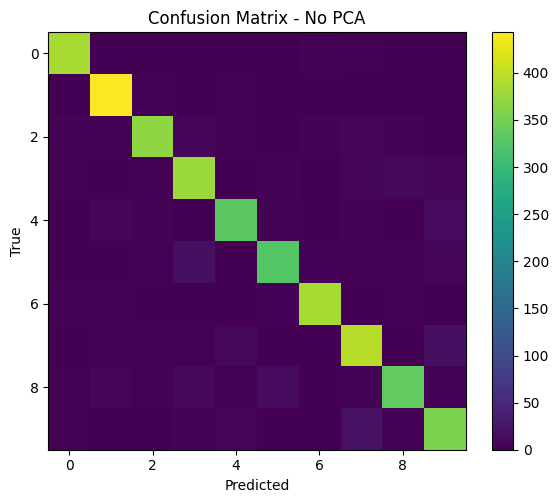


Training PCA (k=64) + KNN (grid search over neighbors/weights)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
PCA+KNN best params: {'knn__n_neighbors': 5, 'knn__weights': 'distance'} CV acc: 0.9368750971570144 took 15.5s

--- PCA(k=64) Test accuracy: 0.9437 ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       393
           1       0.98      0.99      0.98       448
           2       0.96      0.95      0.96       408
           3       0.92      0.91      0.91       412
           4       0.94      0.94      0.94       366
           5       0.94      0.92      0.93       365
           6       0.97      0.98      0.98       399
           7       0.93      0.95      0.94       431
           8       0.92      0.92      0.92       382
           9       0.90      0.90      0.90       396

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg     

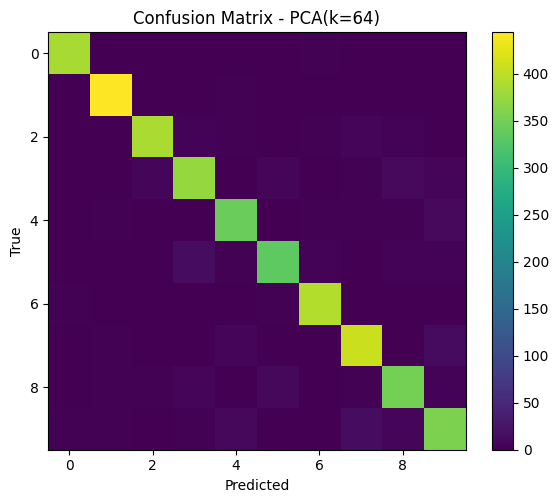


Displaying original vs PCA-reconstructed (k=64) for a few test images...


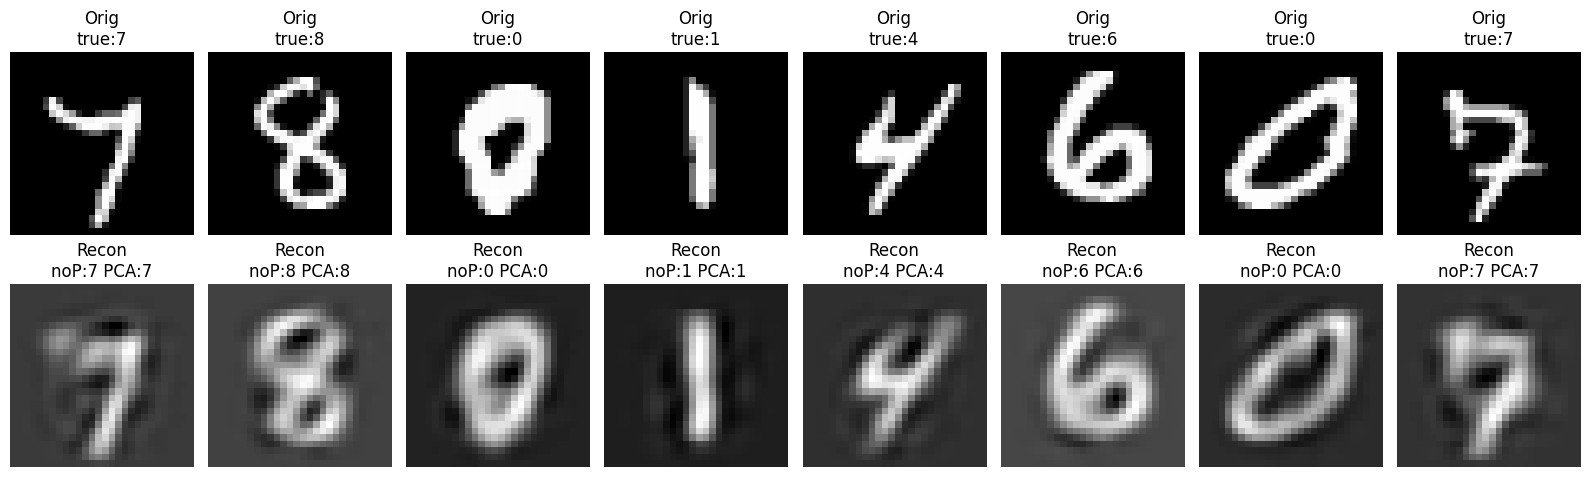

Plotting first PCA components (visualized as 28x28 images)...


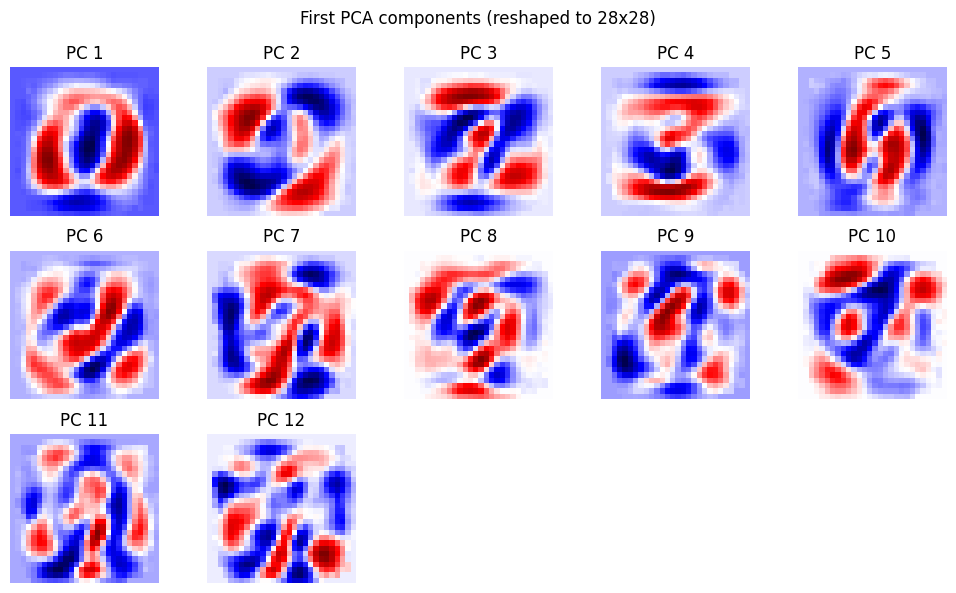

Saved best models to /content/results_visual


In [1]:
# PCA vs NO-PCA visual comparison + evaluation on MNIST
# Paste into a Jupyter cell. Requirements: scikit-learn, numpy, matplotlib, pandas, joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pathlib import Path
import joblib
import time
from sklearn.utils import check_random_state

# ---------- Utility: load MNIST ----------
def load_mnist(openml_name="mnist_784", as_frame=False, verbose=True):
    try:
        if verbose: print("Fetching MNIST from OpenML...")
        X, y = fetch_openml(openml_name, version=1, return_X_y=True, as_frame=as_frame)
        y = y.astype(int)
        if verbose: print("Loaded MNIST via OpenML:", X.shape, y.shape)
        return X, y
    except Exception as e:
        print("OpenML failed:", e)
        print("Falling back to tensorflow.keras.datasets.mnist ...")
        from tensorflow.keras.datasets import mnist
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        X = np.vstack([x_train.reshape(len(x_train), -1), x_test.reshape(len(x_test), -1)])
        y = np.concatenate([y_train, y_test]).astype(int)
        if verbose: print("Loaded MNIST via Keras:", X.shape, y.shape)
        return X, y

# ---------- Plot helpers ----------
def show_original_vs_reconstructed(X_orig, X_recon, y_true=None, y_pred_no_pca=None, y_pred_pca=None, n_cols=5, title_suffix=""):
    n = min(n_cols, len(X_orig))
    plt.figure(figsize=(2*n, 5))
    for i in range(n):
        # original
        plt.subplot(2, n, i+1)
        plt.imshow(X_orig[i].reshape(28,28), cmap='gray', interpolation='nearest')
        label = f"true:{y_true[i]}" if y_true is not None else ""
        plt.title("Orig\n"+label)
        plt.axis('off')

        # reconstructed
        plt.subplot(2, n, n + i + 1)
        plt.imshow(X_recon[i].reshape(28,28), cmap='gray', interpolation='nearest')
        preds = []
        if y_pred_no_pca is not None:
            preds.append(f"noP:{y_pred_no_pca[i]}")
        if y_pred_pca is not None:
            preds.append(f"PCA:{y_pred_pca[i]}")
        plt.title("Recon\n" + " ".join(preds) + ((" " + title_suffix) if title_suffix else ""))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_pca_components(pca, n_components=10):
    comps = pca.components_[:n_components]
    cols = min(5, n_components)
    rows = (n_components + cols - 1)//cols
    plt.figure(figsize=(2*cols, 2*rows))
    for i, comp in enumerate(comps):
        plt.subplot(rows, cols, i+1)
        plt.imshow(comp.reshape(28,28), cmap='seismic', interpolation='nearest')
        plt.title(f"PC {i+1}")
        plt.axis('off')
    plt.suptitle("First PCA components (reshaped to 28x28)")
    plt.tight_layout()
    plt.show()

def plot_confusion(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main experiment ----------
def experiment(subset=20000, test_size=0.2, random_state=42, pca_k=64, cv=3, n_jobs=-1):
    rng = check_random_state(random_state)
    X, y = load_mnist()
    # optionally use subset for speed
    if subset is not None and subset < len(X):
        idx = rng.choice(len(X), subset, replace=False)
        X = X[idx]
        y = y[idx]
        print("Using subset:", X.shape, y.shape)

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    print("Train/test sizes:", X_train.shape, X_test.shape)

    # ----------------- Baseline: KNN WITHOUT PCA -----------------
    pipe_no_pca = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])
    param_grid_knn = {
        'knn__n_neighbors': [3,5],      # keep small for speed
        'knn__weights': ['uniform','distance']
    }
    print("\nGrid searching KNN (no PCA)...")
    gs_no_pca = GridSearchCV(pipe_no_pca, param_grid_knn, cv=cv, n_jobs=n_jobs, scoring='accuracy', verbose=1)
    t0 = time.time()
    gs_no_pca.fit(X_train, y_train)
    print("No-PCA best params:", gs_no_pca.best_params_, "CV acc:", gs_no_pca.best_score_, "took {:.1f}s".format(time.time()-t0))

    # evaluate on test
    best_no_pca = gs_no_pca.best_estimator_
    y_pred_no_pca = best_no_pca.predict(X_test)
    acc_no_pca = accuracy_score(y_test, y_pred_no_pca)
    print("\n--- NO PCA Test accuracy: {:.4f} ---".format(acc_no_pca))
    print(classification_report(y_test, y_pred_no_pca))
    cm_no_pca = confusion_matrix(y_test, y_pred_no_pca)
    plot_confusion(cm_no_pca, title="Confusion Matrix - No PCA")

    # ----------------- PCA + KNN -----------------
    pipe_pca = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca_k, svd_solver='auto')),
        ('knn', KNeighborsClassifier())
    ])
    # We'll grid-search only KNN params here for speed (PCA k chosen as pca_k)
    print(f"\nTraining PCA (k={pca_k}) + KNN (grid search over neighbors/weights)...")
    gs_pca = GridSearchCV(pipe_pca, param_grid_knn, cv=cv, n_jobs=n_jobs, scoring='accuracy', verbose=1)
    t0 = time.time()
    gs_pca.fit(X_train, y_train)
    print("PCA+KNN best params:", gs_pca.best_params_, "CV acc:", gs_pca.best_score_, "took {:.1f}s".format(time.time()-t0))

    best_pca_pipe = gs_pca.best_estimator_
    y_pred_pca = best_pca_pipe.predict(X_test)
    acc_pca = accuracy_score(y_test, y_pred_pca)
    print("\n--- PCA(k={}) Test accuracy: {:.4f} ---".format(pca_k, acc_pca))
    print(classification_report(y_test, y_pred_pca))
    cm_pca = confusion_matrix(y_test, y_pred_pca)
    plot_confusion(cm_pca, title=f"Confusion Matrix - PCA(k={pca_k})")

    # ----------------- Visual comparison: reconstruction -----------------
    # pick a few examples from test set to show reconstruction
    n_show = 8
    sel = rng.choice(len(X_test), n_show, replace=False)
    X_test_sel = X_test[sel]
    y_test_sel = y_test[sel]
    # reconstruct via PCA pipeline:
    # pipeline steps: scaler -> pca -> knn
    scaler = best_pca_pipe.named_steps['scaler']
    pca = best_pca_pipe.named_steps['pca']

    X_scaled = scaler.transform(X_test_sel)                    # scaled
    X_pca_latent = pca.transform(X_scaled)                    # compressed
    X_recon_scaled = pca.inverse_transform(X_pca_latent)      # inverse to scaled space
    X_recon = scaler.inverse_transform(X_recon_scaled)        # back to pixel space

    # get predictions from both models for these selected images
    y_pred_no_pca_sel = best_no_pca.predict(X_test_sel)
    y_pred_pca_sel = best_pca_pipe.predict(X_test_sel)

    # plot original vs reconstructed
    print("\nDisplaying original vs PCA-reconstructed (k={}) for a few test images...".format(pca_k))
    show_original_vs_reconstructed(
        X_test_sel, X_recon, y_true=y_test_sel,
        y_pred_no_pca=y_pred_no_pca_sel, y_pred_pca=y_pred_pca_sel,
        n_cols=min(8, n_show)
    )

    # plot first PCA components as images
    print("Plotting first PCA components (visualized as 28x28 images)...")
    plot_pca_components(pca, n_components=12)

    # ----------------- Save models / results (optional) -----------------
    out = Path("results_visual")
    out.mkdir(exist_ok=True)
    joblib.dump(best_no_pca, out / "knn_no_pca.joblib")
    joblib.dump(best_pca_pipe, out / f"knn_pca_k{pca_k}.joblib")
    print("Saved best models to", out.resolve())

    return {
        'gs_no_pca': gs_no_pca,
        'gs_pca': gs_pca,
        'acc_no_pca': acc_no_pca,
        'acc_pca': acc_pca,
        'cm_no_pca': cm_no_pca,
        'cm_pca': cm_pca
    }

# Run experiment - for quick demo use subset=10000 or less
results = experiment(subset=20000, pca_k=64, cv=3, n_jobs=-1)
